In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split

In [2]:
ctg=pd.read_csv('CTG.csv')
ctg

,Ticker,Date,Open,High,Low,Close,Volume
0,CTG,7/16/2009,10.470000,11.778750,10.470000,10.496170,2401900.0
1,CTG,7/17/2009,10.103510,10.208210,9.972637,9.972637,1002480.0
2,CTG,7/20/2009,9.475024,9.475024,9.475024,9.475024,156560.0
3,CTG,7/21/2009,9.004166,9.292089,9.004166,9.135040,2133390.0
4,CTG,7/22/2009,9.291805,9.396502,9.160935,9.265632,949090.0
...,...,...,...,...,...,...,...
3654,CTG,03/07/2024,36.000000,36.050000,35.450000,35.800000,8882900.0
3655,CTG,03/08/2024,35.800000,35.850000,34.500000,34.500000,20828300.0
3656,CTG,03/11/2024,34.500000,34.750000,33.900000,34.150000,7842600.0
3657,CTG,03/12/2024,34.000000,34.600000,33.950000,34.500000,6760600.0


In [3]:
print(ctg.dtypes)

Ticker     object
Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


In [4]:
ctg=ctg[['Date', 'Close']]
ctg['Date'] = pd.to_datetime(ctg['Date'])


C:\Users\DELL\AppData\Local\Temp\ipykernel_10896\1708959147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctg['Date'] = pd.to_datetime(ctg['Date'])


In [5]:
ctg['Date'].min(), ctg['Date'].max()

(Timestamp('2009-07-16 00:00:00'), Timestamp('2024-03-13 00:00:00'))

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ctg['Date'], y=ctg['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='CTG Stock Price')
fig.show()

In [7]:
train, test = ctg.loc[ctg['Date'] <= '2019-12-01'], ctg.loc[ctg['Date'] > '2019-12-01']
train.shape, test.shape


((2590, 2), (1069, 2))

In [8]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

C:\Users\DELL\AppData\Local\Temp\ipykernel_10896\1980345901.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DELL\AppData\Local\Temp\ipykernel_10896\1980345901.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

In [10]:
print(f'Training shape: {X_train.shape}')

print(f'Testing shape: {X_test.shape}')

Training shape: (2560, 30, 1)
Testing shape: (1039, 30, 1)


In [11]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, y_train, epochs=150, batch_size=60, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - loss: 0.3610 - val_loss: 0.2368
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 0.2237 - val_loss: 0.3318
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - loss: 0.2108 - val_loss: 0.3405
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - loss: 0.1916 - val_loss: 0.2721


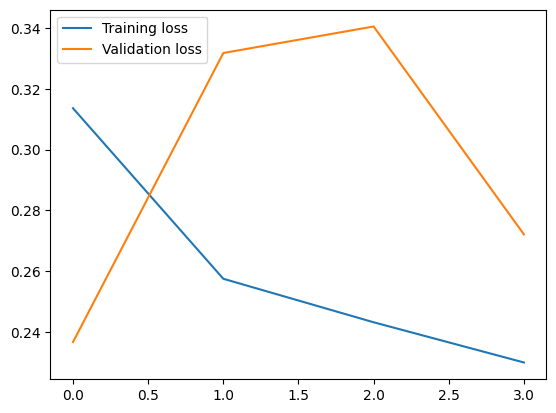

In [13]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [14]:
model.evaluate(X_test, y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.5351


0.6102911829948425

Reconstruction error threshold: 1.0817384886336072


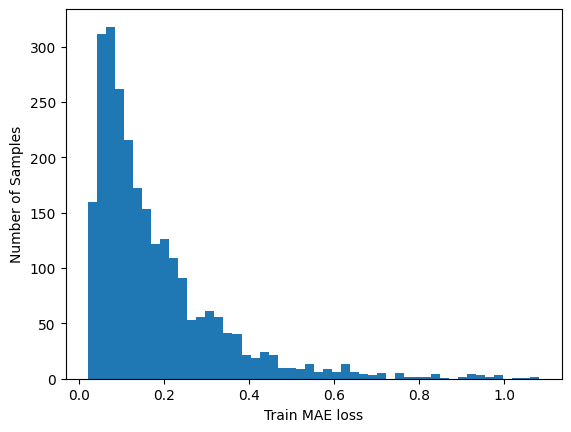

In [15]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Text(0, 0.5, 'Number of samples')

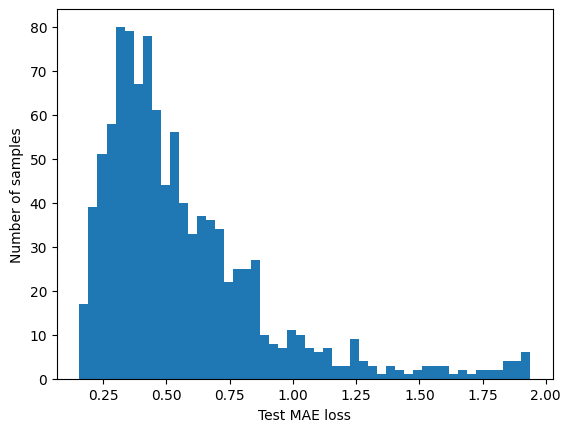

In [16]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [17]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

In [18]:
test_score_df.tail()

,Date,Close,loss,threshold,anomaly
3654,2024-03-07,7.739614,1.437364,1.081738,True
3655,2024-03-08,7.337124,1.484734,1.081738,True
3656,2024-03-11,7.228761,1.533560,1.081738,True
3657,2024-03-12,7.337124,1.572609,1.081738,True
3658,2024-03-13,7.538369,1.604259,1.081738,True


In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [20]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
2970,2021-06-11,7.742930,1.081933,1.081738,True
2971,2021-06-14,7.659094,1.123689,1.081738,True
2972,2021-06-15,7.575259,1.189253,1.081738,True
2973,2021-06-16,7.239913,1.247788,1.081738,True
2974,2021-06-17,7.239913,1.319089,1.081738,True


In [21]:
anomalies.shape

(79, 5)

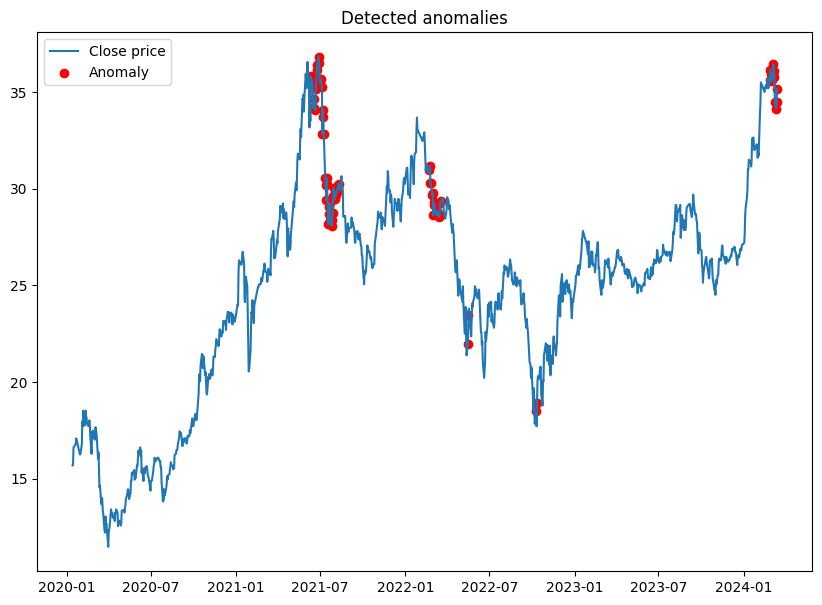

In [22]:
test_score_transformed = scaler.inverse_transform(test_score_df['Close'].values.reshape(-1, 1))
anomalies_transformed = scaler.inverse_transform(anomalies['Close'].values.reshape(-1, 1))

# Vẽ biểu đồ
plt.figure(figsize=(10, 7))
plt.plot(test_score_df['Date'], test_score_transformed, label='Close price')
plt.scatter(anomalies['Date'], anomalies_transformed, color='red', label='Anomaly')
plt.legend()
plt.title('Detected anomalies')
plt.show()